In [1]:
!pip install "numpy<2.0"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 58.4 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


In [2]:
pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 20.3 MB/s eta 0:00:00


Cell 1


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [5]:
# Load and parse dates
df = pd.read_csv('/content/sample_data/dengue data 17-07-2025.csv')
# If you have a date column:
# df['date'] = pd.to_datetime(df['date'])
# df.set_index('date', inplace=True)

cell 2


In [6]:
# Fill numeric NaNs with median
numeric_cols = df.select_dtypes(include=np.number).columns
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())
display(df.head())

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
0,sj,1990,18,30-04-1990,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,...,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,4
1,sj,1990,19,07-05-1990,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,...,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,5
2,sj,1990,20,14-05-1990,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,...,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,4
3,sj,1990,21,21-05-1990,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,...,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0,3
4,sj,1990,22,28-05-1990,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,...,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8,6


Cell 3


In [11]:
result = adfuller(df['total_cases'])
print(f"ADF Statistic: {result[0]:.4f}")
print(f"p-value:        {result[1]:.4f}")
# p-value < 0.05 suggests stationarity; otherwise we need differencing

ADF Statistic: -6.6233
p-value:        0.0000


Cell 4: (Optional) Variance Stabilization

In [8]:
# You can log-transform to stabilize variance
df['y_transformed'] = np.log1p(df['total_cases'])

Cell 5: ACF & PACF for p and q Orders

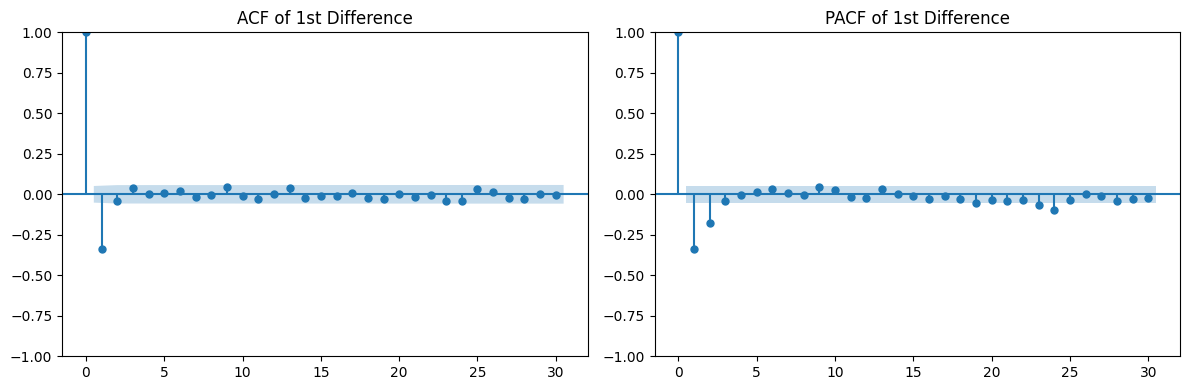

In [24]:
series = df['y_transformed']  # or df['total_cases'] if untransformed

plt.figure(figsize=(12,4))
plt.subplot(121)
plot_acf(series.diff().dropna(), lags=30, ax=plt.gca())
plt.title('ACF of 1st Difference')

plt.subplot(122)
plot_pacf(series.diff().dropna(), lags=30, ax=plt.gca())
plt.title('PACF of 1st Difference')
plt.tight_layout()
plt.show()

Cell 6: Train/Test Split (80/20)

In [12]:
n = len(df)
train_size = int(0.8 * n)

train = series.iloc[:train_size]
test  = series.iloc[train_size:]

Cell 7: Auto-ARIMA Hyperparameter Search

In [13]:
# Pure ARIMA: seasonal=False
auto_model = auto_arima(
    train,
    seasonal=False,
    stepwise=False,    # thorough search
    max_p=5, max_q=5,
    d=None,            # let it pick d via AIC
    information_criterion='aic',
    suppress_warnings=True,
    trace=True
)
print(auto_model.summary())
# Retrieve orders
p, d, q = auto_model.order

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1471.199, Time=0.15 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1274.038, Time=0.46 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1274.460, Time=0.40 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=1260.583, Time=0.55 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=1257.597, Time=0.78 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,5)(0,0,0)[0] intercept   : AIC=1254.030, Time=1.00 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1311.706, Time=0.20 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1275.012, Time=0.45 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1252.752, Time=1.43 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1247.999, Time=1.53 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=1249.792, Time=2.47 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1266.913, Time=0.32 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1268.325, Time=1.00 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1248.518, Time=2.99 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=1249.660, Time=1.84 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=1268.161, Time=0.35 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1269.748, Time=1.50 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=1250.049, Time=3.58 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=1269.647, Time=0.51 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=1259.220, Time=5.11 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=1269.153, Time=2.04 sec

Best model:  ARIMA(1,1,3)(0,0,0)[0] intercept
Total fit time: 28.724 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1164
Model:               SARIMAX(1, 1, 3)   Log Likelihood                -617.999
Date:                Fri, 18 Jul 2025   AIC                           1247.999
Time:                        06:53:46   BIC                           1278.351
Sample:                             0   HQIC                          1259.450
                               - 1164                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0004      0.002      0.159      0.874      -0.005

Cell 8: Fit Final ARIMA with statsmodels

In [14]:
model = SARIMAX(
    train,
    order=(p, d, q),
    enforce_stationarity=False,
    enforce_invertibility=False
)
res = model.fit(disp=False)
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:          y_transformed   No. Observations:                 1164
Model:               SARIMAX(1, 1, 3)   Log Likelihood                -617.331
Date:                Fri, 18 Jul 2025   AIC                           1244.662
Time:                        06:55:21   BIC                           1269.938
Sample:                             0   HQIC                          1254.200
                               - 1164                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7469      0.080      9.392      0.000       0.591       0.903
ma.L1         -1.2006      0.081    -14.850      0.000      -1.359      -1.042
ma.L2          0.3228      0.057      5.643      0.0

Cell 9: Forecast Test and Future Weeks

In [21]:
# Forecast the test period
n_test = len(test)
fc_test = res.get_forecast(steps=n_test).predicted_mean
fc_test.index = test.index

# Ask user for future horizon
n_future = int(input("Enter number of future weeks to forecast: "))
fc_future = res.get_forecast(steps=n_future).predicted_mean

# Build future index
last_idx = df.index[-1]
if isinstance(last_idx, pd.Timestamp):
    future_idx = pd.date_range(start=last_idx + pd.offsets.Week(1),
                               periods=n_future, freq='W')
else:
    future_idx = range(n, n + n_future)
fc_future.index = future_idx

Enter number of future weeks to forecast: 500


Cell 10: Plot Actual, Test, and Forecast

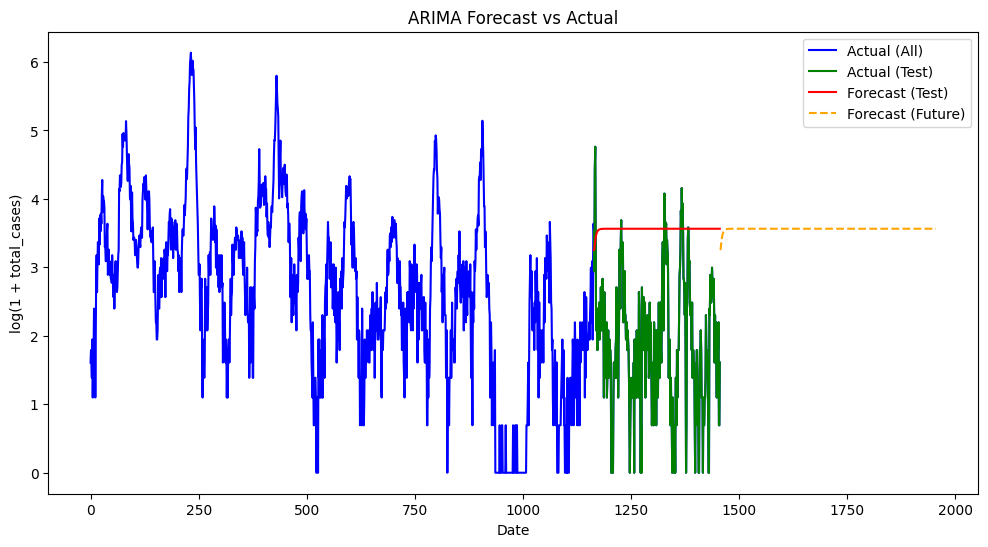

In [22]:
plt.figure(figsize=(12,6))
plt.plot(series,                  label='Actual (All)',       color='blue')
plt.plot(test,                    label='Actual (Test)',      color='green')
plt.plot(fc_test,                 label='Forecast (Test)',    color='red')
plt.plot(fc_future, linestyle='--', label='Forecast (Future)',  color='orange')
plt.title('ARIMA Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('log(1 + total_cases)')
plt.legend()
plt.show()

Cell 11: Inverse Transform (if Applied)

Inverse Transform

In [17]:
# If you used log1p transformation, invert for error metrics and plotting
actual_test = np.expm1(test)
pred_test   = np.expm1(fc_test)
pred_future = np.expm1(fc_future)

Cell 12: Compute Error Metrics

In [18]:
mse   = mean_squared_error(actual_test, pred_test)
rmse  = np.sqrt(mse)
mae   = mean_absolute_error(actual_test, pred_test)
mape  = np.mean(np.abs((actual_test - pred_test) / actual_test)) * 100

print(f"MSE:   {mse:.2f}")
print(f"RMSE:  {rmse:.2f}")
print(f"MAE:   {mae:.2f}")
print(f"MAPE:  {mape:.2f}%")

MSE:   779.86
RMSE:  27.93
MAE:   26.48
MAPE:  inf%


# **Second Code**

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import boxcox
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [26]:
df = pd.read_csv('/content/sample_data/dengue data 17-07-2025.csv')

# Optional: parse date column if available
# df['date'] = pd.to_datetime(df['date'])
# df.set_index('date', inplace=True)

In [27]:
numeric_cols = df.select_dtypes(include=np.number).columns
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())
display(df.head())

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
0,sj,1990,18,30-04-1990,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,...,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,4
1,sj,1990,19,07-05-1990,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,...,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,5
2,sj,1990,20,14-05-1990,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,...,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,4
3,sj,1990,21,21-05-1990,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,...,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0,3
4,sj,1990,22,28-05-1990,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,...,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8,6


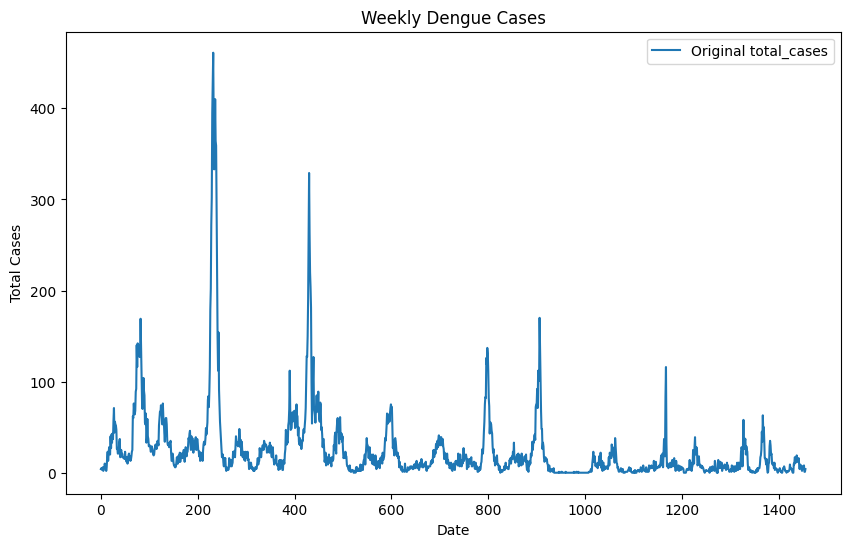

In [28]:
plt.figure(figsize=(10,6))
plt.plot(df['total_cases'], label='Original total_cases')
plt.title('Weekly Dengue Cases')
plt.xlabel('Date')
plt.ylabel('Total Cases')
plt.legend()
plt.show()

In [29]:
y = df['total_cases']
y_transformed, lam = boxcox(y + 1)  # +1 to avoid zero

In [30]:
train_size = int(len(y_transformed) * 0.8)
train = y_transformed[:train_size]
test  = y_transformed[train_size:]

In [41]:
model = auto_arima(
    train,
    seasonal=False,
    stepwise=False,
    max_p=5, max_q=5,
    d=None,
    start_p=0, start_q=0,
    information_criterion='aic',
    suppress_warnings=True,
    trace=True
)
print(model.summary())

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1575.985, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1384.321, Time=0.27 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1384.658, Time=0.40 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=1370.706, Time=0.53 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=1367.650, Time=0.76 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,5)(0,0,0)[0] intercept   : AIC=1363.705, Time=0.97 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1419.552, Time=0.18 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1385.246, Time=0.38 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1362.180, Time=1.32 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1357.270, Time=1.65 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=1359.100, Time=2.97 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1376.993, Time=0.97 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1378.623, Time=0.95 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1357.757, Time=1.31 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=1358.968, Time=2.10 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=1378.511, Time=0.33 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1380.061, Time=1.72 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=1359.361, Time=2.55 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=1379.847, Time=0.49 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=1368.675, Time=3.97 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=1379.032, Time=0.80 sec

Best model:  ARIMA(1,1,3)(0,0,0)[0] intercept
Total fit time: 24.782 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1164
Model:               SARIMAX(1, 1, 3)   Log Likelihood                -672.635
Date:                Fri, 18 Jul 2025   AIC                           1357.270
Time:                        07:15:07   BIC                           1387.623
Sample:                             0   HQIC                          1368.722
                               - 1164                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0004      0.003      0.160      0.873      -0.005

In [32]:
p, d, q = model.order
arima_model = ARIMA(train, order=(p, d, q))
arima_result = arima_model.fit()
print(arima_result.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1164
Model:                 ARIMA(1, 1, 3)   Log Likelihood                -672.649
Date:                Fri, 18 Jul 2025   AIC                           1355.297
Time:                        07:05:01   BIC                           1380.591
Sample:                             0   HQIC                          1364.840
                               - 1164                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7600      0.075     10.067      0.000       0.612       0.908
ma.L1         -1.2085      0.077    -15.728      0.000      -1.359      -1.058
ma.L2          0.3256      0.056      5.853      0.0

In [38]:
n_test = len(test)
n_future = int(input("Enter number of future weeks to forecast: "))

fc_test = arima_result.forecast(steps=n_test)
fc_future = arima_result.forecast(steps=n_test + n_future)[-n_future:]

def inv_boxcox(y, lam):
    return np.expm1(np.log(lam * y + 1) / lam) if lam != 0 else np.expm1(y)

fc_test_inv   = inv_boxcox(fc_test, lam)
fc_future_inv = inv_boxcox(fc_future, lam)

Enter number of future weeks to forecast: 100


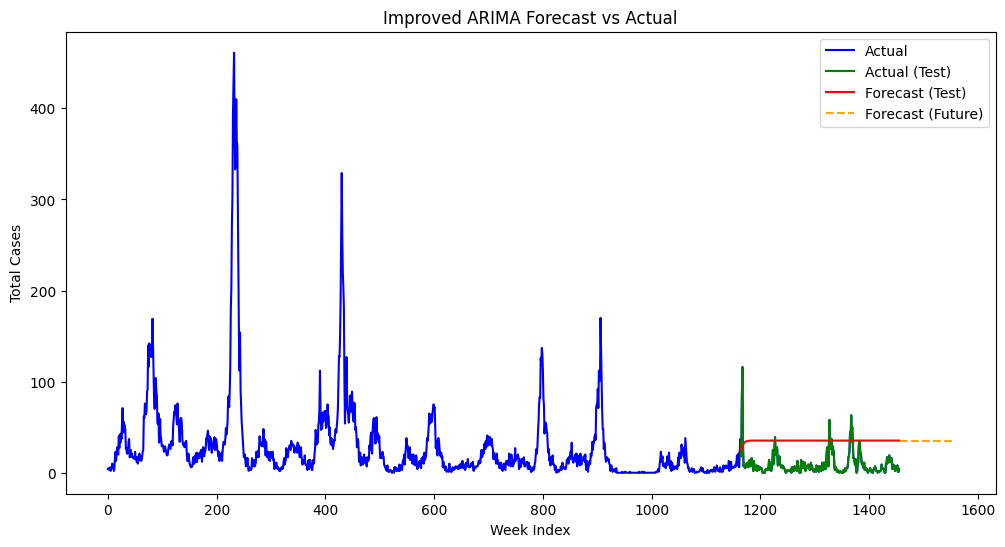

In [39]:
plt.figure(figsize=(12,6))
plt.plot(y, label='Actual', color='blue')
plt.plot(range(train_size, len(y)), y[train_size:], label='Actual (Test)', color='green')
plt.plot(range(train_size, len(y)), fc_test_inv, label='Forecast (Test)', color='red')
plt.plot(range(len(y), len(y) + n_future), fc_future_inv, '--', label='Forecast (Future)', color='orange')
plt.title('Improved ARIMA Forecast vs Actual')
plt.xlabel('Week Index')
plt.ylabel('Total Cases')
plt.legend()
plt.show()

In [35]:
actual_test = y[train_size:]
mse   = mean_squared_error(actual_test, fc_test_inv)
rmse  = np.sqrt(mse)
mae   = mean_absolute_error(actual_test, fc_test_inv)
mape  = np.mean(np.abs((actual_test - fc_test_inv) / actual_test)) * 100

print(f"MSE:   {mse:.2f}")
print(f"RMSE:  {rmse:.2f}")
print(f"MAE:   {mae:.2f}")
print(f"MAPE:  {mape:.2f}%")

MSE:   830.89
RMSE:  28.83
MAE:   27.38
MAPE:  inf%


# **Third Code**

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import boxcox
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings

In [61]:
df = pd.read_csv('/content/sample_data/dengue data 17-07-2025.csv')

# Fill numeric NaNs with median
numeric_cols = df.select_dtypes(include=np.number).columns
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())

df
# Use only total_cases for modeling


,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
0,sj,1990,18,30-04-1990,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,...,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,4
1,sj,1990,19,07-05-1990,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,...,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,5
2,sj,1990,20,14-05-1990,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,...,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,4
3,sj,1990,21,21-05-1990,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,...,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0,3
4,sj,1990,22,28-05-1990,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,...,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1451,iq,2010,21,28-05-2010,0.342750,0.318900,0.256343,0.292514,55.30,299.334286,...,88.765714,55.30,18.485714,9.800000,28.633333,11.933333,35.4,22.4,27.0,5
1452,iq,2010,22,04-06-2010,0.160157,0.160371,0.136043,0.225657,86.47,298.330000,...,91.600000,86.47,18.070000,7.471429,27.433333,10.500000,34.7,21.7,36.6,8
1453,iq,2010,23,11-06-2010,0.247057,0.146057,0.250357,0.233714,58.94,296.598571,...,94.280000,58.94,17.008571,7.500000,24.400000,6.900000,32.2,19.2,7.4,1
1454,iq,2010,24,18-06-2010,0.333914,0.245771,0.278886,0.325486,59.67,296.345714,...,94.660000,59.67,16.815714,7.871429,25.433333,8.733333,31.2,21.0,16.0,1


In [44]:
# Apply Box-Cox to stabilize variance
y = df['total_cases']
y_transformed, lam = boxcox(y + 1)  # +1 to avoid zero

In [45]:
train_size = int(len(y_transformed) * 0.8)
train = y_transformed[:train_size]
test  = y_transformed[train_size:]

In [46]:
warnings.filterwarnings("ignore")

best_aic = np.inf
best_order = None
best_model = None

for p in range(0, 4):
    for d in range(0, 2):
        for q in range(0, 4):
            try:
                model = ARIMA(train, order=(p, d, q))
                result = model.fit()
                if result.aic < best_aic:
                    best_aic = result.aic
                    best_order = (p, d, q)
                    best_model = result
            except:
                continue

print(f"Best ARIMA order: {best_order} with AIC: {best_aic:.2f}")

Best ARIMA order: (2, 0, 3) with AIC: 1335.13


In [59]:
model = SARIMAX(
    train,
    exog=weather_train,
    order=(p, d, q),
    seasonal_order=(P, D, Q, 52)
)

NameError: name 'weather_train' is not defined

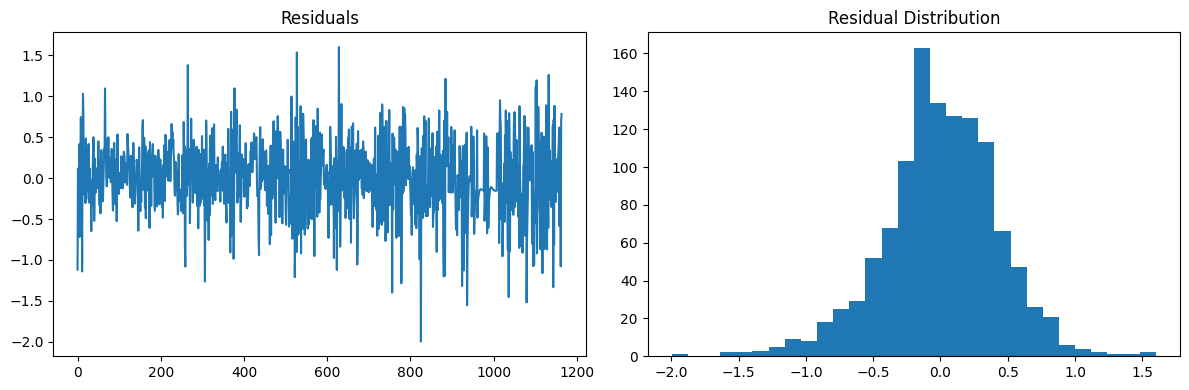

In [47]:
residuals = best_model.resid

plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(residuals)
plt.title('Residuals')

plt.subplot(122)
plt.hist(residuals, bins=30)
plt.title('Residual Distribution')
plt.tight_layout()
plt.show()

In [57]:
n_test = len(test)
n_future = int(input("Enter number of future weeks to forecast: "))

fc_test = best_model.forecast(steps=n_test)
fc_future = best_model.forecast(steps=n_test + n_future)[-n_future:]

def inv_boxcox(y, lam):
    return np.expm1(np.log(lam * y + 1) / lam) if lam != 0 else np.expm1(y)

fc_test_inv   = inv_boxcox(fc_test, lam)
fc_future_inv = inv_boxcox(fc_future, lam)

Enter number of future weeks to forecast: 874


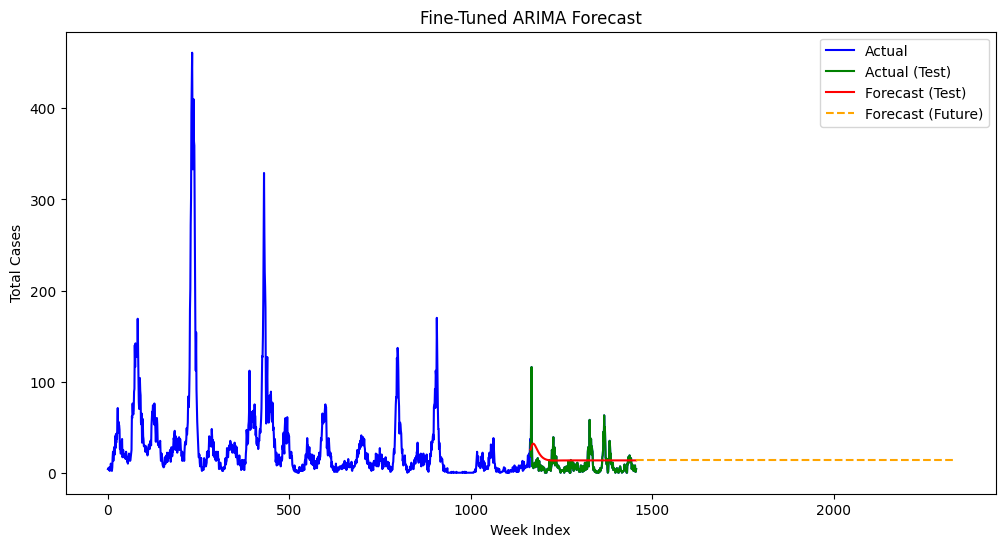

In [58]:
plt.figure(figsize=(12,6))
plt.plot(y, label='Actual', color='blue')
plt.plot(range(train_size, len(y)), y[train_size:], label='Actual (Test)', color='green')
plt.plot(range(train_size, len(y)), fc_test_inv, label='Forecast (Test)', color='red')
plt.plot(range(len(y), len(y) + n_future), fc_future_inv, '--', label='Forecast (Future)', color='orange')
plt.title('Fine-Tuned ARIMA Forecast')
plt.xlabel('Week Index')
plt.ylabel('Total Cases')
plt.legend()
plt.show()

In [53]:
actual_test = y[train_size:]
mse   = mean_squared_error(actual_test, fc_test_inv)
rmse  = np.sqrt(mse)
mae   = mean_absolute_error(actual_test, fc_test_inv)
mape  = np.mean(np.abs((actual_test - fc_test_inv) / actual_test)) * 100

print(f"MSE:   {mse:.2f}")
print(f"RMSE:  {rmse:.2f}")
print(f"MAE:   {mae:.2f}")
print(f"MAPE:  {mape:.2f}%")

MSE:   185.50
RMSE:  13.62
MAE:   10.91
MAPE:  inf%


# **SARIMAX Code**

In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pmdarima.arima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [63]:
df = pd.read_csv('/content/sample_data/dengue data 17-07-2025.csv')

# Convert date column if needed
df['week_start_date'] = pd.to_datetime(df['week_start_date'])
df.set_index('week_start_date', inplace=True)

# Fill missing values
df.fillna(df.median(numeric_only=True), inplace=True)

# Target variable
y = df['total_cases']

# Exogenous features (weather + NDVI)
exog_cols = [
    'precipitation_amt_mm',
    'reanalysis_air_temp_k',
    'reanalysis_relative_humidity_percent',
    'reanalysis_specific_humidity_g_per_kg',
    'station_avg_temp_c',
    'station_precip_mm'
]
X = df[exog_cols]

In [64]:
train_size = int(len(df) * 0.8)
y_train = y[:train_size]
y_test  = y[train_size:]

X_train = X[:train_size]
X_test  = X[train_size:]

In [65]:
model = auto_arima(
    y_train,
    exogenous=X_train,
    seasonal=True,
    m=52,  # weekly seasonality
    stepwise=True,
    suppress_warnings=True,
    trace=True
)
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[52] intercept   : AIC=inf, Time=59.25 sec
 ARIMA(0,1,0)(0,0,0)[52] intercept   : AIC=9160.738, Time=0.05 sec
 ARIMA(1,1,0)(1,0,0)[52] intercept   : AIC=9147.968, Time=10.44 sec
 ARIMA(0,1,1)(0,0,1)[52] intercept   : AIC=9150.677, Time=6.79 sec
 ARIMA(0,1,0)(0,0,0)[52]             : AIC=9158.744, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[52] intercept   : AIC=9146.277, Time=0.07 sec
 ARIMA(1,1,0)(0,0,1)[52] intercept   : AIC=9147.998, Time=9.05 sec
 ARIMA(1,1,0)(1,0,1)[52] intercept   : AIC=inf, Time=37.01 sec
 ARIMA(2,1,0)(0,0,0)[52] intercept   : AIC=9138.478, Time=0.31 sec
 ARIMA(2,1,0)(1,0,0)[52] intercept   : AIC=9140.329, Time=12.31 sec
 ARIMA(2,1,0)(0,0,1)[52] intercept   : AIC=9140.342, Time=12.24 sec
 ARIMA(2,1,0)(1,0,1)[52] intercept   : AIC=inf, Time=47.67 sec
 ARIMA(3,1,0)(0,0,0)[52] intercept   : AIC=9140.478, Time=0.39 sec
 ARIMA(2,1,1)(0,0,0)[52] intercept   : AIC=9140.477, Time=0.42 sec
 ARIMA(1,1,1)(0,0,0)[52] int

In [66]:
order = model.order
seasonal_order = model.seasonal_order

sarimax_model = SARIMAX(
    y_train,
    exog=X_train,
    order=order,
    seasonal_order=seasonal_order,
    enforce_stationarity=False,
    enforce_invertibility=False
)
result = sarimax_model.fit()
print(result.summary())

                               SARIMAX Results                                
Dep. Variable:            total_cases   No. Observations:                 1164
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -4554.014
Date:                Fri, 18 Jul 2025   AIC                           9126.027
Time:                        07:35:51   BIC                           9171.540
Sample:                             0   HQIC                          9143.199
                               - 1164                                         
Covariance Type:                  opg                                         
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
precipitation_amt_mm                     -0.0009      0.008     -0.108      0.914      -0.017       0.016
reanalysis_air_temp_k                     0.5227  

Enter number of future weeks to forecast: 100


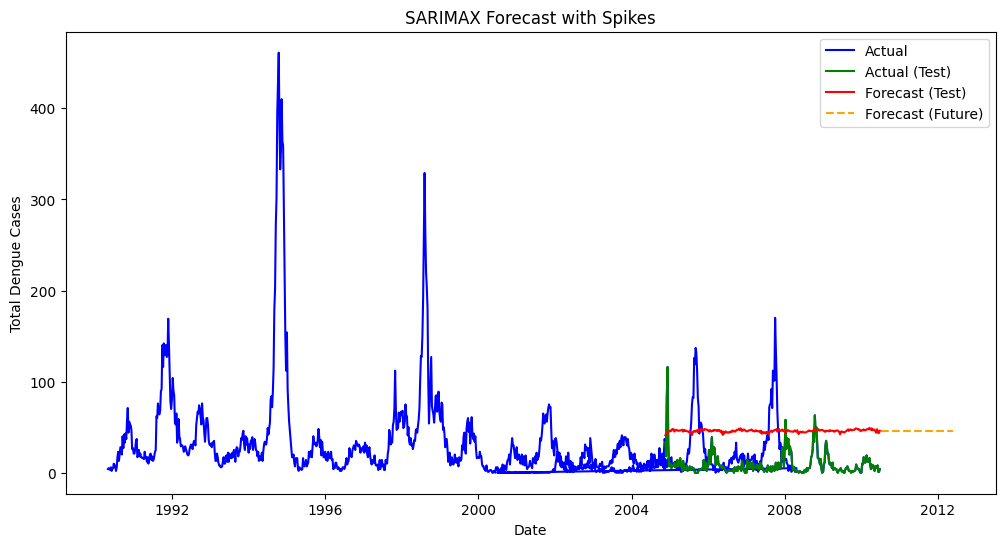

In [82]:
# # Total forecast steps = test + future
# n_test = len(y_test)
# n_future = int(input("Enter number of future weeks to forecast: "))
# n_total = n_test + n_future
# # Use actual test exog
# X_test_actual = X_test.copy()
# #
# # Repeat last known weather for future
# last_known = X.iloc[-1].values.reshape(1, -1)
# X_future = np.tile(last_known, (n_future, 1))

# # Combine test + future exog
# X_pred = np.vstack([X_test_actual.values, X_future])  # shape (n_total, 6)
# fc_all = result.predict(
#     start=len(y_train),
#     end=len(y_train) + n_total - 1,
#     exog=X_pred
# )

# # Split into test and future
# fc_test = fc_all[:n_test]
# fc_future = fc_all[n_test:]
# plt.figure(figsize=(12,6))
# plt.plot(y, label='Actual', color='blue')
# plt.plot(y_test.index, y_test, label='Actual (Test)', color='green')
# plt.plot(y_test.index, fc_test, label='Forecast (Test)', color='red')
# future_index = pd.date_range(start=y_test.index[-1] + pd.Timedelta(weeks=1), periods=n_future, freq='W')
# plt.plot(future_index, fc_future, '--', label='Forecast (Future)', color='orange')
# plt.title('SARIMAX Forecast with Spikes')
# plt.xlabel('Date')
# plt.ylabel('Total Dengue Cases')
# plt.legend()
# plt.show()

In [85]:

# Step 1: Forecast horizon
n_test = len(y_test)
n_future = int(input("Enter number of future weeks to forecast: "))
n_total = n_test + n_future

# Step 2: Build exogenous array for test + future
X_test_actual = X_test.copy()

# Repeat last known weather for future
last_known = X.iloc[-1].values.reshape(1, -1)  # shape (1, 6)
X_future = np.tile(last_known, (n_future, 1))  # shape (n_future, 6)

# Combine test + future exog
X_pred = np.vstack([X_test_actual.values, X_future])  # shape (n_total, 6)

# Step 3: Predict test + future
fc_all = result.predict(
    start=len(y_train),
    end=len(y_train) + n_total - 1,
    exog=X_pred
)

# Split forecast into test and future
fc_test = fc_all[:n_test]
fc_future = fc_all[n_test:]


Enter number of future weeks to forecast: 100


In [ ]:
plt.figure(figsize=(12,6))
plt.plot(y, label='Actual', color='blue')
plt.plot(y_test.index, y_test, label='Actual (Test)', color='green')
plt.plot(y_test.index, fc_test, label='Forecast (Test)', color='red')

# Create future index
future_index = pd.date_range(start=y_test.index[-1] + pd.Timedelta(weeks=1), periods=n_future, freq='W')
plt.plot(future_index, fc_future, '--', label='Forecast (Future)', color='orange')

plt.title('SARIMAX Forecast with Exogenous Variables')
plt.xlabel('Date')
plt.ylabel('Total Dengue Cases')
plt.legend()
plt.show()

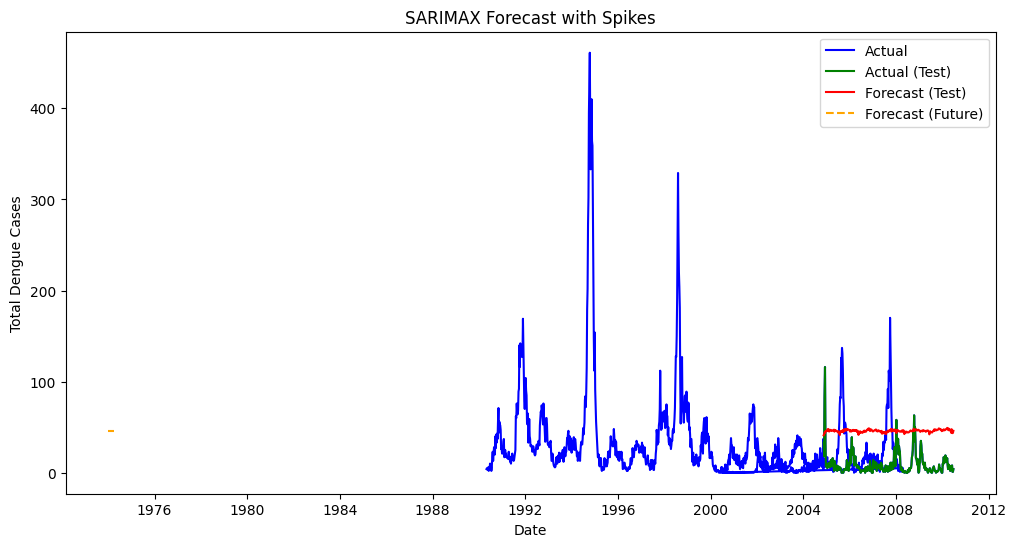

In [86]:
plt.figure(figsize=(12,6))
plt.plot(y, label='Actual', color='blue')
plt.plot(y_test.index, y_test, label='Actual (Test)', color='green')
plt.plot(y_test.index, fc_test, label='Forecast (Test)', color='red')
plt.plot(fc_future.index, fc_future, '--', label='Forecast (Future)', color='orange')
plt.title('SARIMAX Forecast with Spikes')
plt.xlabel('Date')
plt.ylabel('Total Dengue Cases')
plt.legend()
plt.show()

In [83]:
mse   = mean_squared_error(y_test, fc_test)
rmse  = np.sqrt(mse)
mae   = mean_absolute_error(y_test, fc_test)
mape  = np.mean(np.abs((y_test - fc_test) / y_test)) * 100

print(f"MSE:   {mse:.2f}")
print(f"RMSE:  {rmse:.2f}")
print(f"MAE:   {mae:.2f}")
print(f"MAPE:  {mape:.2f}%")

MSE:   1490.43
RMSE:  38.61
MAE:   37.49
MAPE:  nan%
